# Floor plans for the histopathology lab

This notebook plots floor plans for the histopathology lab at Addenbrooke's Hospital, Cambridge,
UK.

In [1]:
import matplotlib.pyplot as plt
from histopath_bim_des.bim import BimModel

**NOTE:** running this notebook requires a copy of "histo.ifc", which is not shared publically due
to confidentially concerns.

In [2]:
bim_model = BimModel.from_ifc('../assets/private/histo.ifc')
l3_model = bim_model.to_shapely(level=3)
l4_model = bim_model.to_shapely(level=4)

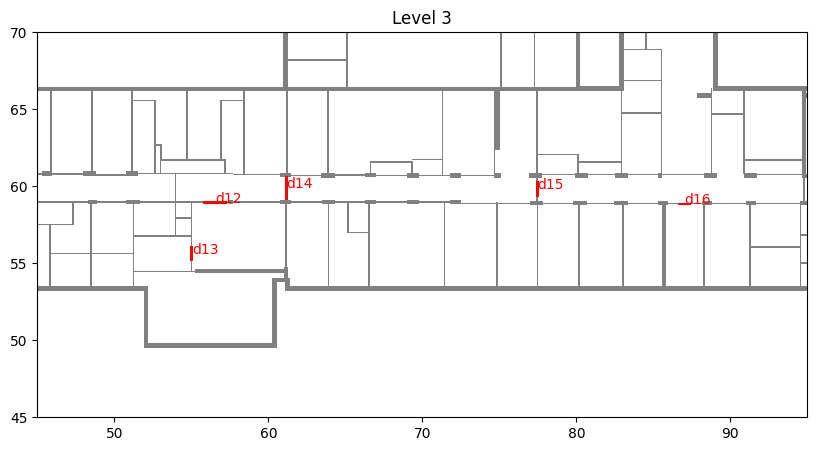

In [3]:
fig = plt.figure(figsize=(10,5))
ax=fig.subplots()
l3_model.plot_floor(ax, 'Level 3', bottom_left=(45,45), top_right=(95,70))

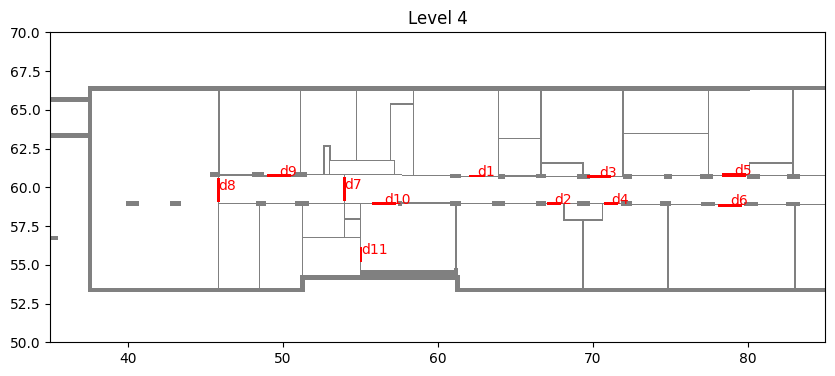

In [4]:
fig = plt.figure(figsize=(10,5))
ax=fig.subplots()
l4_model.plot_floor(ax, 'Level 4', bottom_left=(35,50), top_right=(85,70))

## Grid approximation of floor layouts

For pathfinding, we need to convert the floor layouts into a grid form.

In [58]:
from histopath_bim_des.bim import ShapelyModel
import numpy as np
import networkx as ntx
import shapely as shp
from shapely.plotting import plot_polygon

def box_type(
        model: ShapelyModel,
        box: shp.Polygon) -> str:
    shp.prepare(box)
    if any(box.intersects(list(model.door_shapes.values()))):
        # Intersects with door in ok_doors
        return 'door'
    if any(box.intersects(model.wall_shapes)):
        # Intersects with wall
        return 'wall'
    return 'empty'

def grid_plot(model, ax, title,
              bottom_left,
              top_right,
              grid_size = 0.5,):
    x_min, y_min = bottom_left
    x_max, y_max = top_right
    n_x = len(np.arange(x_min, x_max, grid_size))
    n_y = len(np.arange(y_min, y_max, grid_size))

    # Create base grid, assigning 'box' and 'pos' attributes
    # to each node
    grid = ntx.grid_2d_graph(n_x, n_y)
    for n in grid.nodes:
        i, j = n
        x0 = x_min + i*grid_size
        y0 = y_min + j*grid_size
        grid.nodes[n]['box'] = shp.box(
            x0, y0, x0+grid_size, y0+grid_size, ccw=False
        )
        shp.prepare(grid.nodes[n]['box'])
        centroid = grid.nodes[n]['box'].centroid
        grid.nodes[n]['pos'] = (centroid.x, centroid.y)

    for n, v in grid.nodes(data=True):
        grid.nodes[n]['type'] = t = box_type(model, v['box'])
        grid.nodes[n]['color'] = 'gray' if t == 'wall' else 'red' if t == 'door' else 'white'
    
    for n, v in grid.nodes(data=True):
        plot_polygon(
            v['box'], ax, facecolor=v['color'], add_points=False, linewidth=0.3,
            edgecolor=('#aaa' if v['type'] == 'empty' else "black")
        )
    
    for n, p in model.door_shapes.items():
        ax.text(p.centroid.x+0.2, p.centroid.y+0.2, n, color='#204')

    ax.axis('square')
    x0, y0 = bottom_left
    x1, y1 = top_right
    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    ax.set_title(title)

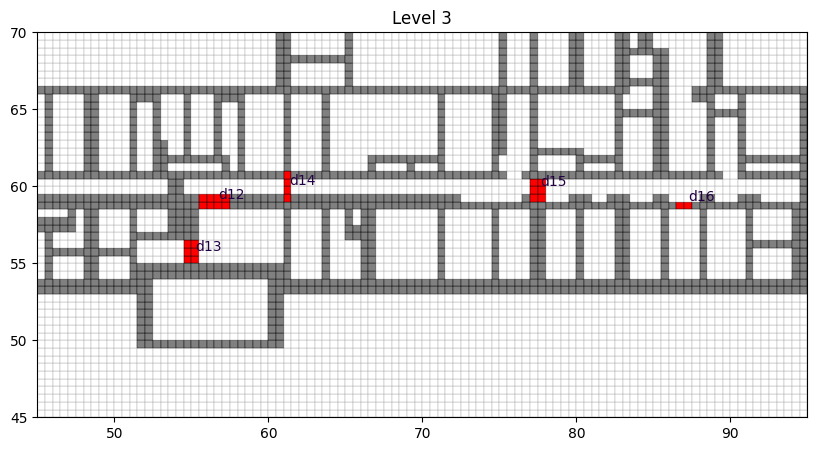

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
grid_plot(l3_model, ax, 'Level 3', bottom_left=(45,45), top_right=(95,70))

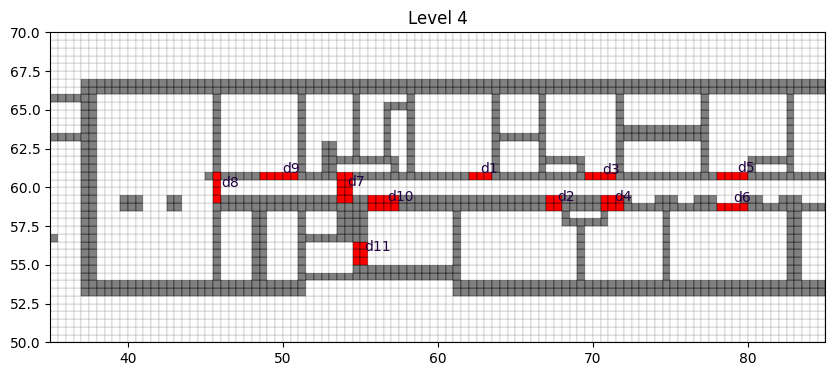

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
grid_plot(l4_model, ax, 'Level 4', bottom_left=(35,50), top_right=(85,70))